In [1]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import sys
workingdir = '/content/gdrive/My Drive/Colab Notebooks/EVA4/Session12'
sys.path.append(workingdir)

In [3]:
%matplotlib inline
import torch
import torchvision
import numpy as np
from utils import datapreparation
from utils import display
from model import dnn
from model import resnet
from utils import training
from utils import evaluate
from utils import lrfinder
from utils import lrrangetest
from utils import gradcam 
from utils import gradvisualize 

  pip install torch-lr-finder -v --global-option="amp"


In [4]:
classes, trainloader, testloader = datapreparation.load('tinyimagenet', 70, batch_size=512, split=True, albumentations=True)


CUDA Available? True


shape: torch.Size([512, 3, 64, 64])


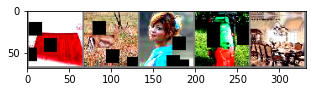

n02906734 n02423022 n03617480 n03649909 n03201208


In [5]:
display.show_random_images(trainloader, classes, 5)

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
net = resnet.ResNet18(num_classes=200)
model = net.to(device)
summary(model, input_size=(3, 64, 64))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1,

In [7]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau

criterion = nn.CrossEntropyLoss()

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


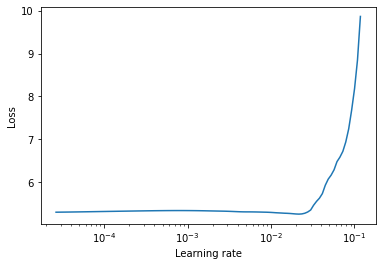

In [8]:
#LR Finder Test
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

lr_finder =lrfinder.LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(trainloader,testloader, start_lr=1e-5, end_lr=2, num_iter=len(trainloader), step_mode="exp")
lr_finder.plot()
lr_finder.reset()

In [9]:
best_loss = lr_finder.best_loss
best_lr = lr_finder.history["lr"][lr_finder.history["loss"].index(best_loss)]
print("Best Loss: %s\nBest Learning Rate: %s" % (best_loss, best_lr))

Best Loss: 5.257871906305646
Best Learning Rate: 0.021631423330401627


In [10]:
#LR Finder Best Learning Rate:
#best_lr = 0.008199949724922407
best_lr = 0.021631423330401627

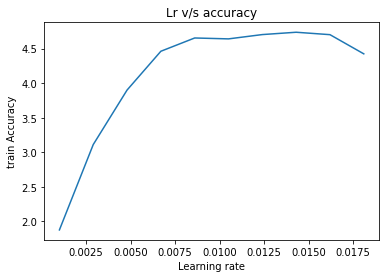

In [11]:
#LR Range Test
max_lr = 0.02
min_lr = 0.001
lr_rangetest_epoch = 10
lrrangetest.LR_test(max_lr, min_lr, device, lr_rangetest_epoch, model, criterion, trainloader, momemtum = 0.9, weight_decay=0.05, plot= True)

In [12]:
#best_lr = 0.008199949724922407
#optimizer = optim.SGD(model.parameters(), lr=best_lr, momentum=0.9)
#scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=3,verbose=True, min_lr=1e-5)

In [13]:
#Use the values obtained from LR Range Test, the max accuracy is achieved at 0.014, hence this is max_lr, and min_lr is .10 times max_lr
initial_lr = 0.001
max_lr = 0.014
min_lr = max_lr * 0.1

EPOCHS = 50
steps_per_epoch = len(trainloader)
num_steps = steps_per_epoch * EPOCHS
peak_lr_epoch = 20 
pct_start = float (peak_lr_epoch/EPOCHS)
div_factor = float (max_lr/initial_lr)
final_div_factor = float (initial_lr/min_lr)

print("maxlr: ", max_lr)
print("min_lr: ", min_lr)
print("initial_lr: ", initial_lr)
print("epochs: ", EPOCHS)
print("steps_per_epoch: ", steps_per_epoch)
print("pct_start: ", pct_start)
print("div_factor: ", div_factor)
print("final_div_factor: ", final_div_factor)


optimizer = optim.SGD(model.parameters(), lr=max_lr, momentum=0.9)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr, 
                                                epochs=EPOCHS, 
                                                steps_per_epoch=steps_per_epoch, 
                                                pct_start=pct_start, 
                                                anneal_strategy='cos', 
                                                cycle_momentum=True, 
                                                base_momentum=0.85, 
                                                max_momentum=0.95, 
                                                div_factor=div_factor, 
                                                final_div_factor=final_div_factor, 
                                                last_epoch=-1)

maxlr:  0.014
min_lr:  0.0014000000000000002
initial_lr:  0.001
epochs:  50
steps_per_epoch:  151
pct_start:  0.4
div_factor:  14.0
final_div_factor:  0.7142857142857142


In [14]:
misclassified_imgs = []
correct_imgs = []
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1,'LR:',optimizer.param_groups[0]['lr'])
    training.train_model(epoch, model, device, trainloader, criterion, optimizer, scheduler)
    misclassified_imgs, correct_imgs = training.test_model(model, device, testloader, criterion, epoch==EPOCHS-1)

  0%|          | 0/151 [00:00<?, ?it/s]

EPOCH: 1 LR: 0.0009999999999999992


Loss=4.884147644042969 Batch_id=150 Accuracy=2.43: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0097, Accuracy: 1302/33000 (3.95%)

EPOCH: 2 LR: 0.0010800787005333448


Loss=4.491644382476807 Batch_id=150 Accuracy=6.14: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0090, Accuracy: 2359/33000 (7.15%)

EPOCH: 3 LR: 0.0013183416949705765


Loss=4.293849945068359 Batch_id=150 Accuracy=9.65: 100%|██████████| 151/151 [02:13<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0086, Accuracy: 3234/33000 (9.80%)

EPOCH: 4 LR: 0.0017089182783948612


Loss=3.8971495628356934 Batch_id=150 Accuracy=13.11: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0079, Accuracy: 4573/33000 (13.86%)

EPOCH: 5 LR: 0.002242184799957159


Loss=3.8288495540618896 Batch_id=150 Accuracy=16.28: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0076, Accuracy: 5164/33000 (15.65%)

EPOCH: 6 LR: 0.0029050017857852727


Loss=3.675750732421875 Batch_id=150 Accuracy=19.24: 100%|██████████| 151/151 [02:14<00:00,  1.12it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0073, Accuracy: 5834/33000 (17.68%)

EPOCH: 7 LR: 0.0036810376903664184


  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0071, Accuracy: 6539/33000 (19.82%)

EPOCH: 8 LR: 0.004551171299298731


Loss=3.3065919876098633 Batch_id=150 Accuracy=24.86: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0068, Accuracy: 7361/33000 (22.31%)

EPOCH: 9 LR: 0.00549396286836876


Loss=3.126962661743164 Batch_id=150 Accuracy=27.80: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0065, Accuracy: 8176/33000 (24.78%)

EPOCH: 10 LR: 0.006486182390276533


Loss=2.9870994091033936 Batch_id=150 Accuracy=30.15: 100%|██████████| 151/151 [02:13<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0064, Accuracy: 8320/33000 (25.21%)

EPOCH: 11 LR: 0.007503381972727224


Loss=2.7092676162719727 Batch_id=150 Accuracy=32.66: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0061, Accuracy: 9505/33000 (28.80%)

EPOCH: 12 LR: 0.008520498224722148


Loss=2.7358193397521973 Batch_id=150 Accuracy=34.61: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0061, Accuracy: 9675/33000 (29.32%)

EPOCH: 13 LR: 0.00951246980849174


Loss=2.4683170318603516 Batch_id=150 Accuracy=36.69: 100%|██████████| 151/151 [02:14<00:00,  1.12it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0057, Accuracy: 10646/33000 (32.26%)

EPOCH: 14 LR: 0.010454854940837761


Loss=2.2503151893615723 Batch_id=150 Accuracy=38.60: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0061, Accuracy: 9774/33000 (29.62%)

EPOCH: 15 LR: 0.011324433628898605


Loss=2.3458094596862793 Batch_id=150 Accuracy=40.66: 100%|██████████| 151/151 [02:14<00:00,  1.12it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0055, Accuracy: 11141/33000 (33.76%)

EPOCH: 16 LR: 0.012099779801489224


Loss=2.4341373443603516 Batch_id=150 Accuracy=42.51: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 11485/33000 (34.80%)

EPOCH: 17 LR: 0.012761789238928218


Loss=2.4818553924560547 Batch_id=150 Accuracy=44.05: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0061, Accuracy: 10168/33000 (30.81%)

EPOCH: 18 LR: 0.013294150293372223


Loss=2.228799343109131 Batch_id=150 Accuracy=45.72: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0061, Accuracy: 10598/33000 (32.12%)

EPOCH: 19 LR: 0.0136837458012968


Loss=2.2667975425720215 Batch_id=150 Accuracy=47.35: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 11180/33000 (33.88%)

EPOCH: 20 LR: 0.013920976285160952


Loss=1.9899094104766846 Batch_id=150 Accuracy=48.98: 100%|██████████| 151/151 [02:14<00:00,  1.12it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 12626/33000 (38.26%)

EPOCH: 21 LR: 0.013999998484995658


Loss=1.8782168626785278 Batch_id=150 Accuracy=50.10: 100%|██████████| 151/151 [02:13<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 12539/33000 (38.00%)

EPOCH: 22 LR: 0.013965029738595572


Loss=2.1228928565979004 Batch_id=150 Accuracy=51.58: 100%|██████████| 151/151 [02:14<00:00,  1.12it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 12835/33000 (38.89%)

EPOCH: 23 LR: 0.013861420015337675


Loss=2.046342372894287 Batch_id=150 Accuracy=53.10: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 13140/33000 (39.82%)

EPOCH: 24 LR: 0.013690304485031706


Loss=2.113054037094116 Batch_id=150 Accuracy=54.35: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 14093/33000 (42.71%)

EPOCH: 25 LR: 0.01345355792523593


Loss=1.8216720819473267 Batch_id=150 Accuracy=55.72: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 13964/33000 (42.32%)

EPOCH: 26 LR: 0.013153774180801868


Loss=1.733078956604004 Batch_id=150 Accuracy=56.95: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 13327/33000 (40.38%)

EPOCH: 27 LR: 0.01279423774516732


Loss=1.5715248584747314 Batch_id=150 Accuracy=58.43: 100%|██████████| 151/151 [02:14<00:00,  1.12it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 14563/33000 (44.13%)

EPOCH: 28 LR: 0.01237888777475894


Loss=1.6909458637237549 Batch_id=150 Accuracy=59.57: 100%|██████████| 151/151 [02:14<00:00,  1.12it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 14889/33000 (45.12%)

EPOCH: 29 LR: 0.011912274930770085


Loss=1.579929232597351 Batch_id=150 Accuracy=60.84: 100%|██████████| 151/151 [02:14<00:00,  1.12it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 14277/33000 (43.26%)

EPOCH: 30 LR: 0.011399511521164514


Loss=1.4640579223632812 Batch_id=150 Accuracy=62.05: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 14607/33000 (44.26%)

EPOCH: 31 LR: 0.010846215489160508


Loss=1.6118419170379639 Batch_id=150 Accuracy=63.15: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 15301/33000 (46.37%)

EPOCH: 32 LR: 0.010258448861869345


Loss=1.3722537755966187 Batch_id=150 Accuracy=64.32: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 15885/33000 (48.14%)

EPOCH: 33 LR: 0.009642651333457694


Loss=1.4156068563461304 Batch_id=150 Accuracy=65.62: 100%|██████████| 151/151 [02:14<00:00,  1.12it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 15477/33000 (46.90%)

EPOCH: 34 LR: 0.009005569710510756


Loss=1.3581500053405762 Batch_id=150 Accuracy=66.92: 100%|██████████| 151/151 [02:14<00:00,  1.12it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 15303/33000 (46.37%)

EPOCH: 35 LR: 0.008354183992607435


Loss=1.217847228050232 Batch_id=150 Accuracy=68.44: 100%|██████████| 151/151 [02:14<00:00,  1.12it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 16147/33000 (48.93%)

EPOCH: 36 LR: 0.0076956308979843025


Loss=1.3450530767440796 Batch_id=150 Accuracy=69.56: 100%|██████████| 151/151 [02:14<00:00,  1.12it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 15914/33000 (48.22%)

EPOCH: 37 LR: 0.00703712567215715


Loss=0.9991204142570496 Batch_id=150 Accuracy=71.01: 100%|██████████| 151/151 [02:14<00:00,  1.12it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 15757/33000 (47.75%)

EPOCH: 38 LR: 0.006385883036181216


Loss=1.101668119430542 Batch_id=150 Accuracy=72.33: 100%|██████████| 151/151 [02:14<00:00,  1.12it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 16454/33000 (49.86%)

EPOCH: 39 LR: 0.005749038140657534


Loss=1.0483026504516602 Batch_id=150 Accuracy=73.81: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 16642/33000 (50.43%)

EPOCH: 40 LR: 0.005133568391529822


Loss=0.9339261054992676 Batch_id=150 Accuracy=75.40: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 16043/33000 (48.62%)

EPOCH: 41 LR: 0.004546217004164854


Loss=1.020485281944275 Batch_id=150 Accuracy=76.80: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 17237/33000 (52.23%)

EPOCH: 42 LR: 0.003993419123273773


Loss=0.8106381297111511 Batch_id=150 Accuracy=78.53: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 17255/33000 (52.29%)

EPOCH: 43 LR: 0.0034812313181200195


Loss=0.9171617031097412 Batch_id=150 Accuracy=80.13: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 17255/33000 (52.29%)

EPOCH: 44 LR: 0.0030152652254790482


Loss=0.7911824584007263 Batch_id=150 Accuracy=81.37: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 17346/33000 (52.56%)

EPOCH: 45 LR: 0.002600626067371504


Loss=0.7426108717918396 Batch_id=150 Accuracy=82.84: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 17544/33000 (53.16%)

EPOCH: 46 LR: 0.002241856717182437


Loss=0.5920425653457642 Batch_id=150 Accuracy=84.42: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 17615/33000 (53.38%)

EPOCH: 47 LR: 0.001942887926989831


Loss=0.6548404693603516 Batch_id=150 Accuracy=85.62: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 17790/33000 (53.91%)

EPOCH: 48 LR: 0.0017069952614222773


Loss=0.595126211643219 Batch_id=150 Accuracy=86.30: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 17820/33000 (54.00%)

EPOCH: 49 LR: 0.001536763209887449


Loss=0.5215064287185669 Batch_id=150 Accuracy=87.33: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 17737/33000 (53.75%)

EPOCH: 50 LR: 0.0014340568703653082


Loss=0.5557491779327393 Batch_id=150 Accuracy=88.10: 100%|██████████| 151/151 [02:14<00:00,  1.12it/s]



Test set: Average loss: 0.0040, Accuracy: 17762/33000 (53.82%)



In [15]:
evaluate.evaluate_accuracy(model, device, testloader)

Accuracy of the network on the 10000 test images: 53 %


Gradcam

In [16]:
target_layers = ["layer1","layer2","layer3","layer4"]
viz_cam = gradvisualize.VisualizeCam(model, classes, target_layers)
print (viz_cam)

In [17]:
#len(testloader.dataset)
#print(misclassified_imgs[0]["img"])

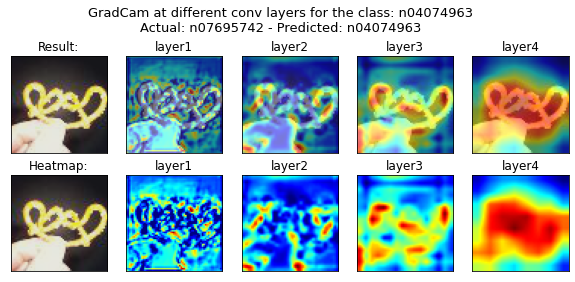

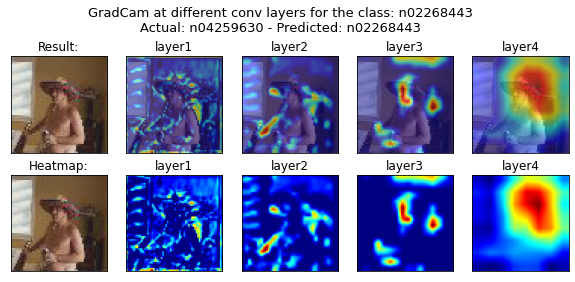

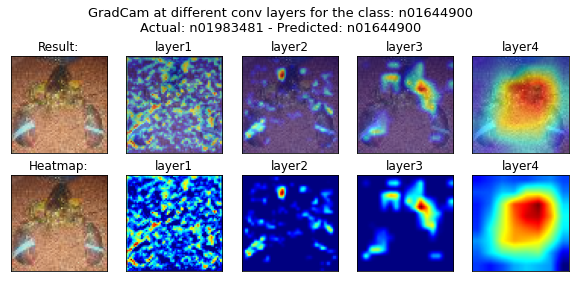

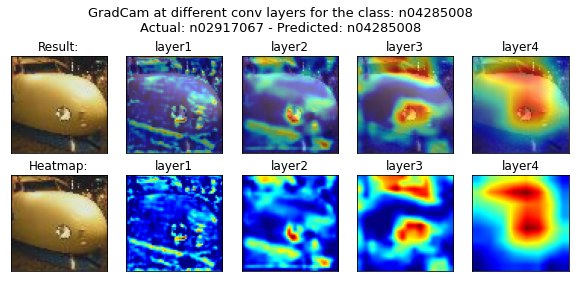

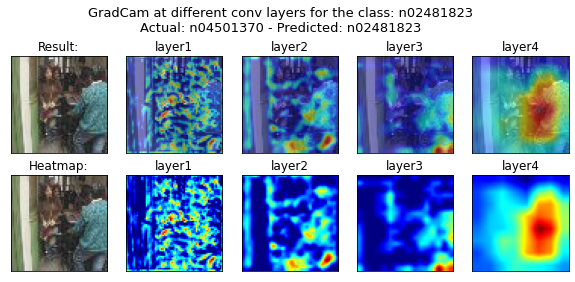

In [18]:
num_img = 5
incorrect_pred_imgs = []
truth_inds = []
for i in range(num_img):
  incorrect_pred_imgs.append(torch.as_tensor(misclassified_imgs[i]["img"]))
  truth_inds.append(misclassified_imgs[i]["target"])
  #incorrect_pred_imgs
viz_cam(torch.stack(incorrect_pred_imgs), truth_inds, target_layers, metric="incorrect")

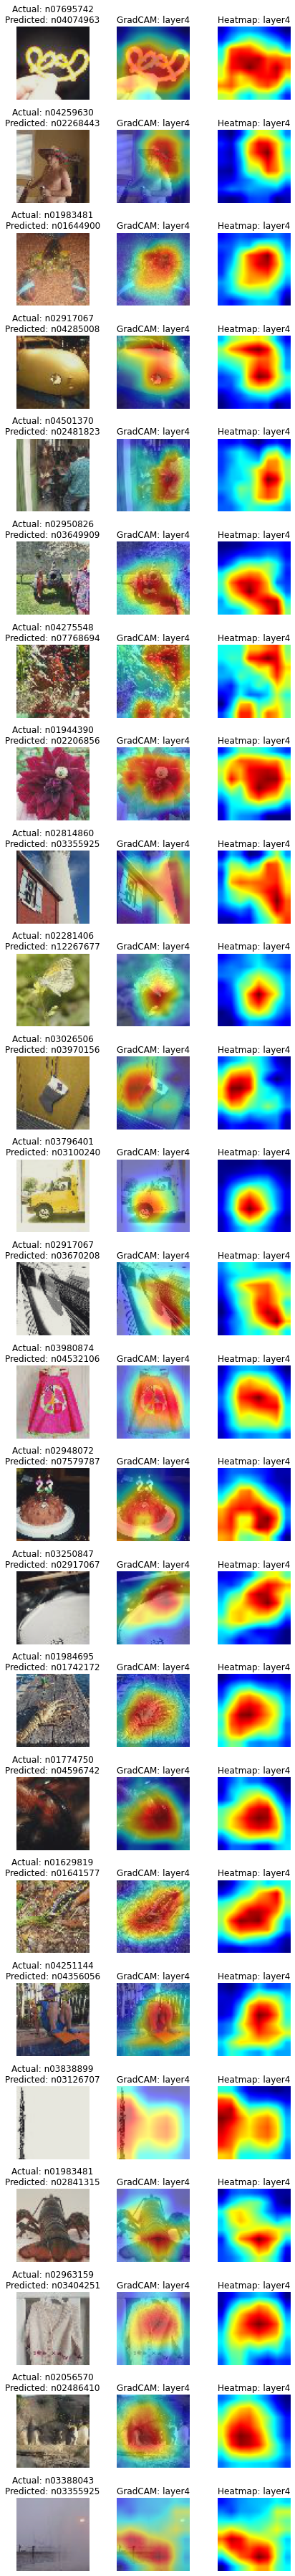

In [19]:
num_img = 25
incorrect_pred_imgs = []
truth_inds = []
for i in range(num_img):
  incorrect_pred_imgs.append(torch.as_tensor(misclassified_imgs[i]["img"]))
  truth_inds.append(misclassified_imgs[i]["target"])
viz_cam(torch.stack(incorrect_pred_imgs), truth_inds, target_layers, metric="incorrect", per_image=False)